In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sps
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from keras.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## Прогнозирование временного ряда с помощью линейной регрессии (регрессионный и корреляционный анализ)

__1. Исходные данные (ETL)__

In [3]:
df = pd.read_excel("D:/Datasets/regression/data_tns.xlsx", engine="openpyxl")
pd.set_option('display.max_rows', None)
df.head()

,Потребление,t,Световой день,Средняя температура,Отопление
0,1239.807717,1,8.50,-4.283333,T
1,1082.035863,2,10.11,-3.066667,T
2,1104.730841,3,11.51,1.166667,T
3,897.962429,4,13.33,10.116667,F
4,840.153646,5,14.59,13.533333,F


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Потребление          60 non-null     float64
 1   t                    60 non-null     int64  
 2   Световой день        60 non-null     float64
 3   Средняя температура  60 non-null     float64
 4   Отопление            60 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.5+ KB


Так как "Отопление" представляет собой категориальную переменную, сделем перекодировку

In [5]:
labelCat = preprocessing.LabelEncoder()
df['Отопление'] = labelCat.fit_transform(df['Отопление'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Потребление          60 non-null     float64
 1   t                    60 non-null     int64  
 2   Световой день        60 non-null     float64
 3   Средняя температура  60 non-null     float64
 4   Отопление            60 non-null     int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 2.2 KB


In [6]:
df.head()

,Потребление,t,Световой день,Средняя температура,Отопление
0,1239.807717,1,8.50,-4.283333,1
1,1082.035863,2,10.11,-3.066667,1
2,1104.730841,3,11.51,1.166667,1
3,897.962429,4,13.33,10.116667,0
4,840.153646,5,14.59,13.533333,0


__2. EDA__

__2.1 Одномерный анализ__

In [7]:
# проверка данных на пропуски
df.isnull().sum()

Потребление            0
t                      0
Световой день          0
Средняя температура    0
Отопление              0
dtype: int64

No handles with labels found to put in legend.


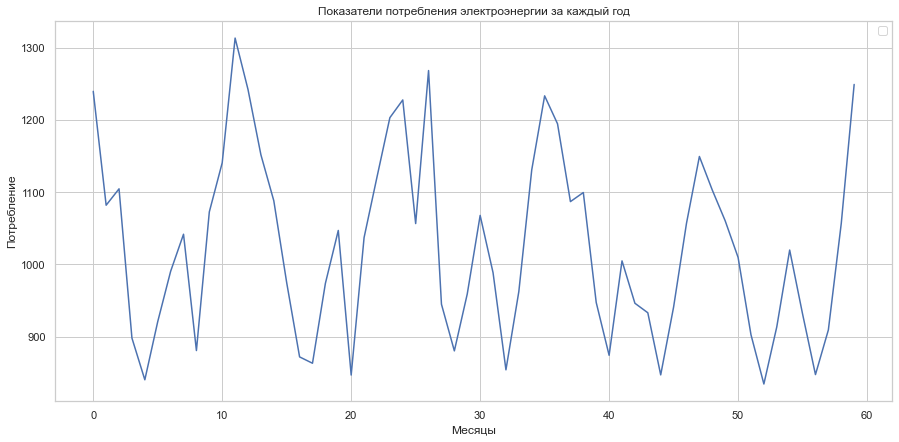

In [10]:
# график потребления электроэнергии
style = 'whitegrid'
fig, axes = plt.subplots(figsize=(15,7)) 
sns.set(style=style)
axes = sns.lineplot(data=df['Потребление'])
axes.set_title('Показатели потребления электроэнергии за каждый год')
axes.set_xlabel('Месяцы')
axes.set_ylabel('Потребление')
axes.tick_params()
axes.legend()

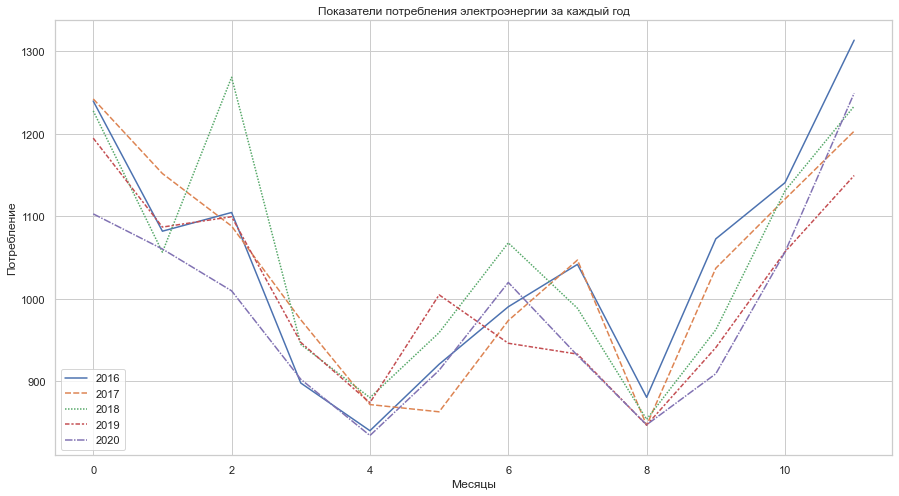

In [9]:
# график потребления в разрезе каждого года за данный период
data_2016 = df['Потребление'][0:12].values
data_2017 = df['Потребление'][12:24].values
data_2018 = df['Потребление'][24:36].values
data_2019 = df['Потребление'][36:48].values
data_2020 = df['Потребление'][48:60].values
df_all = pd.DataFrame({'2016': data_2016,
                       '2017': data_2017,
                       '2018': data_2018,
                       '2019': data_2019,
                       '2020': data_2020})

style = 'whitegrid'
fig, axes = plt.subplots(figsize=(15,8)) 
sns.set(style=style)
axes = sns.lineplot(data=df_all)
axes.set_title('Показатели потребления электроэнергии за каждый год')
axes.set_xlabel('Месяцы')
axes.set_ylabel('Потребление')
axes.tick_params()
axes.legend()

Исходный временной ряд имеет аддитивный тренд и сезонность. На графике потребления за каждый год явно выделяется пик за февральский период 2018 года. Также можем наблюдать значительный прирост потребления в летний период 2018 года. Данный прирост мог быть вызван в связи проведения ЧМ2018 в России. Ростов-на-Дону был одним из организаторов спортивного мероприятия за данный период. Соответственно была повышенная нагрузка на энергосети из-за большого потока туристов.  
Проверим февральский скачок и в целом данные на выбросы

In [11]:
df.describe()

,Потребление,t,Световой день,Средняя температура,Отопление
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1023.996035,30.500000,11.940667,9.388889,0.416667
std,128.359325,17.464249,2.530116,9.893392,0.497167
min,834.303388,1.000000,8.240000,-4.283333,0.000000
25%,918.899837,15.750000,9.957500,0.504167,0.000000
50%,1014.830167,30.500000,11.890000,9.908333,0.000000
75%,1103.444231,45.250000,14.182500,17.850000,1.000000
max,1313.609331,60.000000,15.460000,23.433333,1.000000


array([[<AxesSubplot:title={'center':'Потребление'}>,
        <AxesSubplot:title={'center':'t'}>],
       [<AxesSubplot:title={'center':'Световой день'}>,
        <AxesSubplot:title={'center':'Средняя температура'}>],
       [<AxesSubplot:title={'center':'Отопление'}>, <AxesSubplot:>]],
      dtype=object)

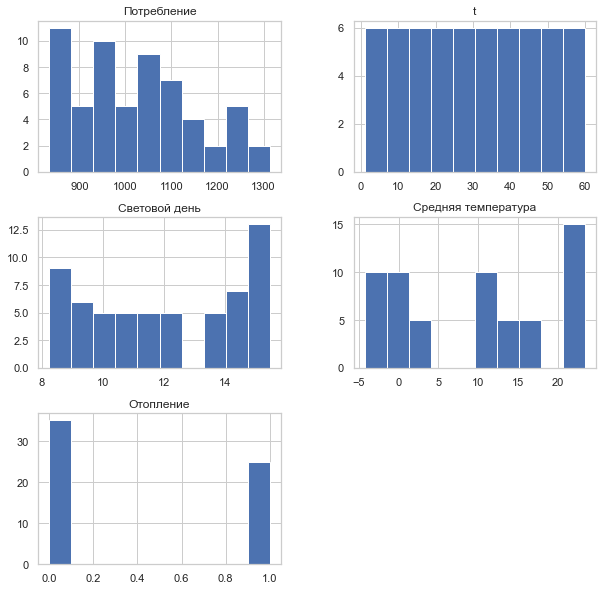

In [12]:
# рассмотрим распределения данных
df.hist(figsize=(10,10))

<AxesSubplot:>

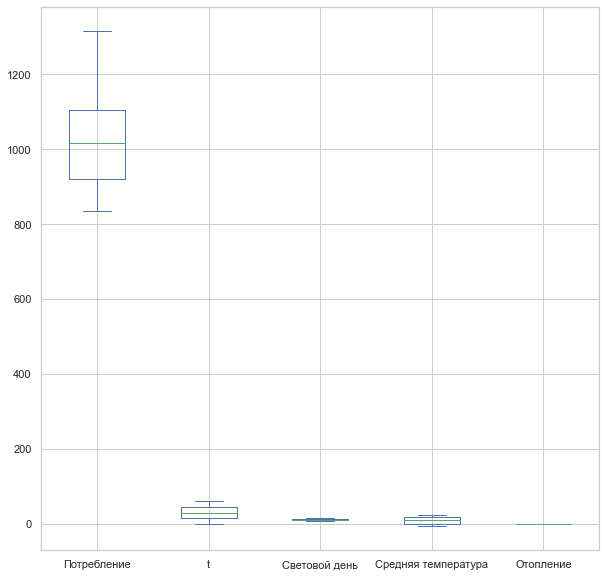

In [13]:
sns.set_style('whitegrid', {'axes.grid': True})
df.plot.box(figsize=(10,10))

Гистограммы оказались в данном случае не информативными. Однако boxplot показывает отсутствие явных выбросов и верхняя граница показателей включает скачок потребления за февральский период 2018 года. Поэтому данное явлеление может объяснятся дополнительными факторами. 

__2.2 Двумерный анализ__

In [14]:
corr = df.corr()
corr

,Потребление,t,Световой день,Средняя температура,Отопление
Потребление,1.000000,-0.163493,-0.724570,-0.707287,0.816122
t,-0.163493,1.000000,-0.017633,0.050667,-0.034161
Световой день,-0.724570,-0.017633,1.000000,0.875131,-0.805716
Средняя температура,-0.707287,0.050667,0.875131,1.000000,-0.890378
Отопление,0.816122,-0.034161,-0.805716,-0.890378,1.000000


<AxesSubplot:>

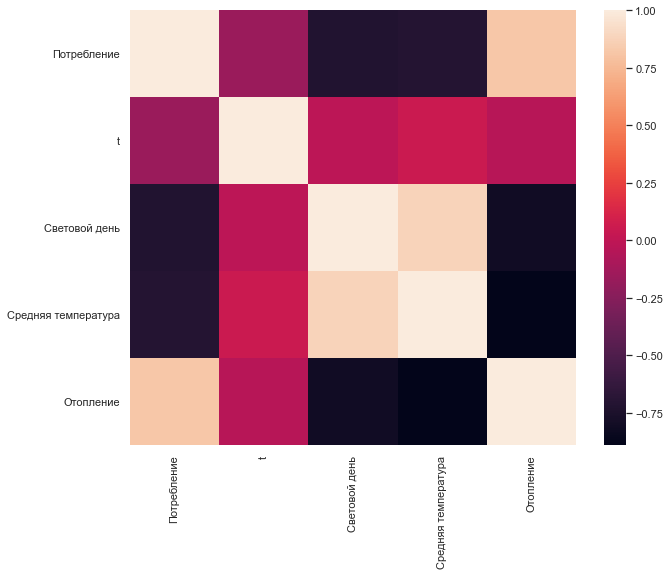

In [15]:
# тепловая карта корреляций между признаками
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr)

Матрица корреляций предварительно показала значительную зависимость целевой переменной и признаков. Однако мы также видим зависимость между самими признаками. Данный показатель свидетельствует подозрение на мультиколлинеарность. Потребуются дополнительные тесты.

__3. Регрессионная модель__

Регрессионная модель входит в список моделей, которой требуется нормализация для приведения данных к одному масштабу

In [16]:
data = StandardScaler().fit_transform(df.values)
data = pd.DataFrame(data, columns=df.columns)
data.head()

,Потребление,t,Световой день,Средняя температура,Отопление
0,1.695497,-1.703420,-1.371361,-1.393617,1.183216
1,0.455983,-1.645677,-0.729656,-1.269602,1.183216
2,0.634283,-1.587934,-0.171653,-0.838096,1.183216
3,-0.990167,-1.530191,0.553752,0.074183,-0.845154
4,-1.444335,-1.472448,1.055956,0.422446,-0.845154


In [17]:
Y = df['Потребление'].values
X = df[['t', 'Световой день', 'Средняя температура', 'Отопление']].values
Y[:5], X[:5], Y.shape, X.shape

(array([1239.807717, 1082.035863, 1104.730841,  897.962429,  840.153646]),
 array([[ 1.        ,  8.5       , -4.28333333,  1.        ],
        [ 2.        , 10.11      , -3.06666667,  1.        ],
        [ 3.        , 11.51      ,  1.16666667,  1.        ],
        [ 4.        , 13.33      , 10.11666667,  0.        ],
        [ 5.        , 14.59      , 13.53333333,  0.        ]]),
 (60,),
 (60, 4))

In [18]:
polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(X)
result = sm.OLS(Y, xp).fit()
predict = result.predict(xp)

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     35.82
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           1.01e-14
Time:                        15:07:01   Log-Likelihood:                -337.45
No. Observations:                  60   AIC:                             684.9
Df Residuals:                      55   BIC:                             695.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1158.3939     89.279     12.975      0.000     979.476    1337.312
x1            -1.1911      0.527     -2.260      0.028      -2.247      -0.135
x2           -20.1317      7.561     -2.663      0.010     -35.285      -4.979
x3             5.3371      2.511      2.125      0.038       0.305      10.369
x4           221.2949     40.576      5.454      0.000     139.979     302.611
==============================================================================
Omnibus:                        2.890   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                1.739
Skew:                           0.149   Prob(JB):                        0.419
Kurtosis:                       2.221   Cond. No.                         384.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Коэффициент детерминации составляет 72%. Проанализируем локальные задачи регрессионного анализа. Однако ряд статистических тестов требует нормальность регрессионных остатков. Построим гистограмму остатков и проведем ряд тестов на нормальность.

c:\users\boris\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


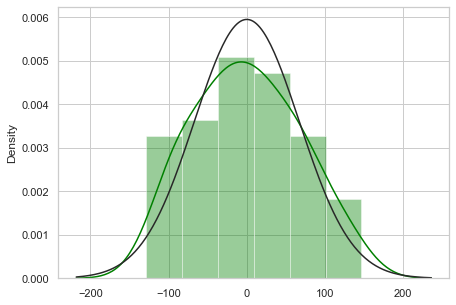

In [20]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 5))
    sns.distplot(result.resid, bins=6, fit=norm, color='green')

In [22]:
def shapiro(e, alpha):
    stat, p_value = sps.stats.shapiro(e)
    if p_value > alpha:
        print('Тест Шапиро-Уилка\nstat=%.3f, p-value=%.3f\nПринять гипотезу о нормальности' % (stat, p_value))
    else:
        print('Отклонить гипотезу о нормальности')

alpha = 0.05
e = result.resid
shapiro(e, alpha)

Тест Шапиро-Уилка
stat=0.981, p-value=0.482
Принять гипотезу о нормальности


In [23]:
def pirson(e, alpha):
    stat, p_value = sps.stats.normaltest(e)
    if p_value > alpha:
        print('Критерий согласия Пирсона\nstat=%.3f, p-value=%.3f\nПринять гипотезу о нормальности' % (stat, p_value))
    else:
        print('Отклонить гипотезу о нормальности')

alpha = 0.05
e = result.resid
pirson(e, alpha)

Критерий согласия Пирсона
stat=2.890, p-value=0.236
Принять гипотезу о нормальности


График распределения остатков похож на нормальный. Статистические тесты подтверждают, что остатки имеют нормальное распределение 

__3.1 Проверка на мультиколлинеарность__

In [24]:
# тест VIF (на мультиколлинеарность)
def vif(data):
    vif = np.diag(np.linalg.inv(np.corrcoef(df_m, rowvar=False)))
    if vif.all() < 10:
        print("Результаты теста VIF: {0}\nМультиколлинеарность отсутствует".format(vif))
    else:
        print("Результаты теста VIF: {0}\nМультиколлинеарность присутствует".format(vif))
        
df_m = df[['t', 'Световой день', 'Средняя температура', 'Отопление']].values
vif(df_m)

Результаты теста VIF: [1.01941561 4.40389959 7.42680423 4.89695628]
Мультиколлинеарность отсутствует


Коэффициент вздутия дисперсии имеет общепринятый порог: 10. Таким образом подозрение на мультиколлинеарность исходя из корреляционной матрицы не подтвердилось

__3.2 Проверка на гетероскедастичность__

In [25]:
# тест Уайта (на гетероскедастичность)
def white(e, exog):  
    res_white = sm.stats.diagnostic.het_white(e, exog)
    stat = res_white[0]
    p_value = res_white[1]
    if p_value > 0.05:
        print("результат статистики: {0}\np-value: {1}\nПрисутствует гомоскедастичность (дисперсия остатков равномерная)".format(stat, p_value))
    else:
        print("результат статистики: {0}\np-value: {1}\nПрисутствует гетероскедастичность (дисперсия остатков неравномерная)".format(stat, p_value))

e = result.resid
exog = result.model.exog
white(e, exog)

результат статистики: 17.16536855985092
p-value: 0.19185425517293556
Присутствует гомоскедастичность (дисперсия остатков равномерная)


Гетероскедастичность остатков также отсутствует. Таким образом стандартные ошибки, могут быть ненадежными на определенном уровне значимости.

__3.3 Проверка на автокорреляцию остатков__

Для проверки остатков на автокорреляцию используют тест Дарбина-Уотсона. Резульат данного теста приведен в summary регрессионной модели. Результат статистики показывающий отсутствие автокорреляции близки к 2. Поэтому автокорреляция в остатках отсутствует

__4. Проверка значимости модели и коэффициентов__

__4.1 Проверка значимости модели в целом__

In [29]:
def regression_model_adequacy_check(
    model_fit,
    p_level: float=0.95,
    model_name=''):
    
    a_level = 1 - p_level
    
    n = int(model_fit.nobs)
    p = int(model_fit.df_model)    # Число степеней свободы регрессии, равно числу переменных модели (за исключением константы, если она присутствует)
    
    SST = model_fit.centered_tss    # SST (Sum of Squared Total)
    dfT = n-1
    MST = SST / dfT

    SSE = model_fit.ssr    # SSE (Sum of Squared Error)
    dfE = n - p - 1
    MSE = SSE / dfE
    
    F_calc = MST / MSE
    F_table = sps.stats.f.ppf(p_level, dfT, dfE, loc=0, scale=1)
    a_calc = 1 - sps.stats.f.cdf(F_calc, dfT, dfE, loc=0, scale=1)
    conclusion_model_adequacy_check = 'adequacy' if F_calc >= F_table else 'adequacy'
    
    # формируем результат            
    result = pd.DataFrame({
        'SST': (SST),
        'SSE': (SSE),
        'dfT': (dfT),
        'dfE': (dfE),
        'MST': (MST),
        'MSE': (MSE),
        'p_level': (p_level),
        'a_level': (a_level),
        'F_calc': (F_calc),
        'F_table': (F_table),
        'F_calc >= F_table': (F_calc >= F_table),
        'a_calc': (a_calc),
        'a_calc <= a_level': (a_calc <= a_level),
        'adequacy_check': (conclusion_model_adequacy_check),
        },
        index=[model_name]
        )
    
    return result

regression_model_adequacy_check(result, p_level=0.95, model_name='linear_ols')

,SST,SSE,dfT,dfE,MST,MSE,p_level,a_level,F_calc,F_table,F_calc >= F_table,a_calc,a_calc <= a_level,adequacy_check
linear_ols,972090.865751,269667.581502,59,55,16476.116369,4903.046936,0.95,0.05,3.360383,1.555239,True,0.000006,True,adequacy


Расчетная F - статистика превышает табличное значние, также p-value показывает что мы отклоняем нулевую гипотезу о не значимости модели. Модель в целом значима.

__4.2 Проверка значимости коэффициентов регрессии__

In [35]:
print("t-тест на значимости коэффициентов регрессии")
# для коэффициентов
t_beta1 = result.t_test([1,0,0,0,0])
t_beta2 = result.t_test([0,1,0,0,0])
t_beta3 = result.t_test([0,0,1,0,0])
t_beta4 = result.t_test([0,0,0,1,0])
t_beta5 = result.t_test([0,0,0,0,1])
t_beta = [t_beta1, t_beta2, t_beta3, t_beta4, t_beta5]
for i in np.arange(1, 6, 1):
    res = "результат t - статистики для признака {0} : {1}".format(str(i), t_beta[i-1])
    print(res)

t-тест на значимости коэффициентов регрессии
результат t - статистики для признака 1 :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          1158.3939     89.279     12.975      0.000     979.476    1337.312
результат t - статистики для признака 2 :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.1911      0.527     -2.260      0.028      -2.247      -0.135
результат t - статистики для признака 3 :                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Расчетная t - статистика превышает табличное значние, также p-value показывает что мы отклоняем нулевую гипотезу о не значимости коэффициентов модели. Признаки оказывают существенное влияние на целевую переменную.

__5. Графики и результаты__

__5.1 Регрессионный график__

<AxesSubplot:title={'center':'График прогнозной регрессионной модели'}, xlabel='Месяцы', ylabel='Потребление'>

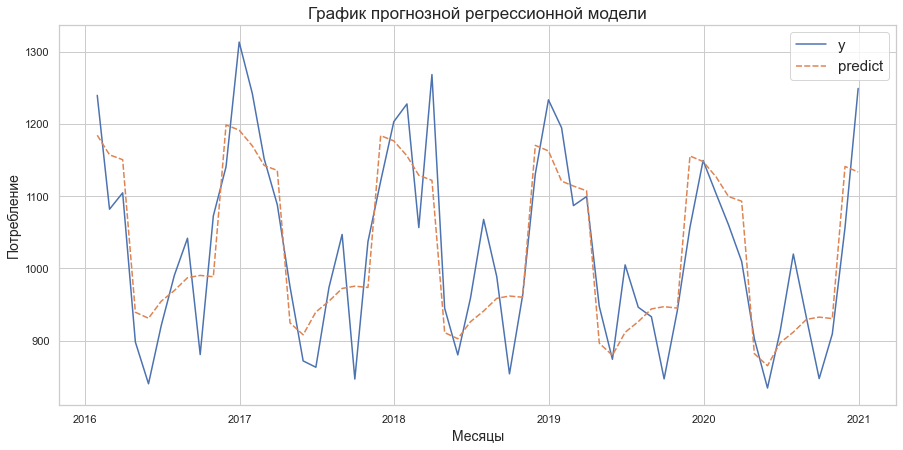

In [36]:
# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)

# график регрессии
df_line = pd.DataFrame({'y': Y,
                   'predict': predict}, index=index_series)

fig, ax = plt.subplots(figsize=(15,7))
sns.set_context({'axes.labelsize': 12, 'legend.fontsize': 15})
sns.set_style('whitegrid', {'axes.grid': True})
ax.set_title('График прогнозной регрессионной модели', fontsize=17)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Потребление', fontsize=14)

sns.lineplot(data=df_line)

__5.2 Построение прогноза c прогнозными интервалами__

In [37]:
# данные для прогноза на 3 месяца вперед
path = "D:/Datasets/regression/predict_step_data.xlsx"
df_x_pred = pd.read_excel(path, engine="openpyxl")
df_x_pred

,Потребление(факт),t,Длительность_светового_дня,Средняя_температура,Отопление
0,1155.504783,61,8.11,-0.9,1
1,1086.290361,62,10.08,-2.0,1
2,1132.221270,63,11.49,2.1,1


In [38]:
# преобразуем данные для прогноза
fact = df_x_pred['Потребление(факт)'].values
x1 = df_x_pred['t'].values
x2 = df_x_pred['Длительность_светового_дня'].values
x3 = df_x_pred['Средняя_температура'].values
x4 = df_x_pred['Отопление'].values
pred_fact = pd.DataFrame({'intercept': 1, 
                          'x1': x1,
                          'x2': x2,
                          'x3': x3,
                          'x4': x4})
y_pred = result.predict(pred_fact) 


# Доверительные интервалы для прогноза
# result.conf_int(alpha=0.05)
# 1. mean: прогнозные значения
# 2. mean_se: стандартное отклонение прогноза (или регрессии)
# 3. ci_lower, ci_upper: доверительные границы
predictions = result.get_prediction(exog=pred_fact.values).summary_frame(alpha=0.05)
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1138.962429,23.254329,1092.359712,1185.565145,991.099627,1286.825230
1,1092.240995,23.385965,1045.374473,1139.107517,944.294836,1240.187154
2,1084.546372,26.056308,1032.328364,1136.764380,934.818902,1234.273842


__5.3 Оценка прогноза__

Для оценки резульататов будем использовать метрику RMSE. RMSE представляет собой корень из среднеквадратичной ошибки, что позволяет хорошо интерпретировать результат. RMSE таже позволяет привести масштаб ошибок к масштабу цели.

In [60]:
# метрика rmse оценки
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# оценка модели
def rmse_model(Y, result):
    y_pred = result.fittedvalues
    rmse_pred = measure_rmse(Y, y_pred)
    text_result = "Модель в среднем в среднем ошибается на {0} млн.кВт потребления электроэнергии".format(rmse_pred)
    return text_result

# оценка прогноза на n шагов вперед
def rmse_predict_n_step(fact_values, y_pred_step):
    rmse_pred_step = measure_rmse(fact_values, y_pred_step)
    text_result = "Прогноз в среднем в среднем ошибается на {0} млн.кВт потребления электроэнергии".format(rmse_pred_step)
    return text_result


Y = df['Потребление'].values
rmse_model_result = rmse_model(Y, result)
rmse_predict_n_step_result = rmse_predict_n_step(df_x_pred['Потребление(факт)'].values, predictions['mean'].values)

pd.options.display.max_colwidth = 100
rmse_series = pd.DataFrame({'Оценка модели': [rmse_model_result],
                        'Оценка прогноза на n шагов вперед': [rmse_predict_n_step_result]})
rmse_series

,Оценка модели,Оценка прогноза на n шагов вперед
0,Модель в среднем в среднем ошибается на 67.04073158681766 млн.кВт потребления электроэнергии,Прогноз в среднем в среднем ошибается на 29.33686797199013 млн.кВт потребления электроэнергии


__5.4 Прогнозный график__

<AxesSubplot:title={'center':'График прогноза на 3 месяца вперед'}, xlabel='Месяцы', ylabel='Потребление'>

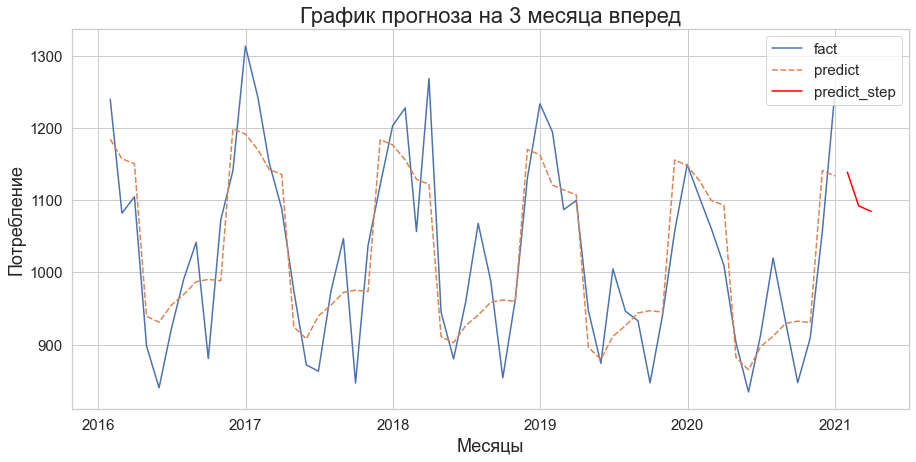

In [53]:
# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)
index_series_pred = pd.date_range('2021-01-01', freq='M', periods=3)


df_line = pd.DataFrame({'fact': Y,
                   'predict': result.fittedvalues}, index=index_series)
    
df_pred = pd.DataFrame({'predict_step': predictions['mean'].values}, index=index_series_pred)

fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('График прогноза на 3 месяца вперед', fontsize=22)
sns.set_context({'axes.labelsize': 12, 'legend.fontsize': 15})
sns.set_style('whitegrid', {'axes.grid': True})
plt.grid(True)
plt.xlabel('Месяцы', fontsize=18)
plt.ylabel('Потребление', fontsize=18)
ax.tick_params(labelsize=15)
sns.lineplot(data=df_line)
sns.lineplot(data=df_pred, palette=['red'])

Модель множественной линейной регрессии показала удовлетворительный результат, не смотря на качественные показатели статистики и учитывая особенности, связанные с исходными данными. Результат:  
- Оценка модели: модель в среднем в среднем ошибается на 67.04073158681766 млн.кВт потребления электроэнергии  
- Оценка прогноза на n шагов вперед: прогноз в среднем в среднем ошибается на 29.33686797199013 млн.кВт потребления электроэнергии  

Однако циклическая составляющая за все периоды календарного года объяснилась посредственно. Ввод дополнительных признаков из открытых источников данных, не дали улучшенного результата, так как признаки оказались не значимы. Для улучшения качества результата регрессионной модели требуется больше данных из предметной области и их анализ.